#  Prévoir les ventes de milliers de familles de produits vendues dans les magasins Favorita situés en Équateur.


NB : L'Équateur est un pays dépendant du pétrole et sa santé économique est très vulnérable aux chocs des prix du pétrole.

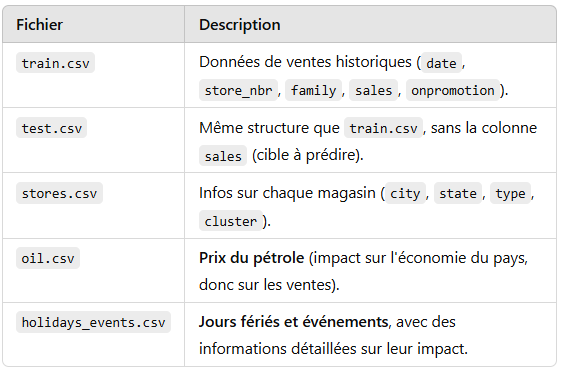

## Introduction

Dans ce projet, nous nous intéressons à la prévision des ventes d’un réseau de supermarchés en Équateur. L'objectif est de développer un modèle capable d'anticiper les ventes futures en exploitant des données historiques et des facteurs contextuels influents.

La prévision des ventes est un enjeu majeur dans le secteur de la grande distribution, car elle permet d’optimiser les stocks, ajuster les stratégies promotionnelles et améliorer la gestion des ressources. Cependant, ce problème est complexe en raison de multiples facteurs influents :

Saisonnalité et tendances (ex : fluctuations mensuelles, pics de consommation),
Effet des promotions et événements spéciaux (ex : jours fériés, séisme d’avril 2016),
Impact des prix du pétrole sur l'économie locale.

## Importation des packages utiles

In [1]:
# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns


# Gestion du temps et des dates
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Machine Learning (ML)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Modèles de prévision
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Séries temporelles classiques
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Deep Learning (si utilisation d'un modèle LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Désactivation des warnings pour un affichage plus propre
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Charger les fichiers nécessaires
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv')
holidays = pd.read_csv('data/holidays_events.csv')
transactions = pd.read_csv('data/transactions.csv')

In [3]:
train.shape

(3000888, 6)

##### Nous disposons de 3000888 lignes et 6 colonnes pour notre base de données d'entraînement 

In [4]:
holidays.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Gestion des jours fériés transférés

Résumé de la Gestion des Jours Fériés et Événements
* Problème rencontré :
Le fichier holidays (des jours fériés) contenait des jours transférés (célébrés à une date différente de leur date officielle).
Sans correction, ces erreurs auraient faussé l’analyse des ventes et la modélisation.

* Solution mise en place :

1️ - Correction des jours transférés

On a identifié les jours transférés et retrouvé leur date réelle de célébration.
Exemple : Independencia de Guayaquil était initialement le 09/10/2012, mais il a été réellement célébré le 12/10/2012.
Chaque jour transféré a été réattribué à sa bonne date.

2️ - Ajout d’indicateurs de jours fériés

Création de nouvelles colonnes pour indiquer si un jour est un jour férié et à quel niveau :
is_national_holiday → Jour férié à l’échelle nationale.
is_regional_holiday → Jour férié dans une région spécifique.
is_local_holiday → Jour férié dans une seule ville.

3️ - Fusion avec train

Les nouvelles informations ont été ajoutées à la base principale (train).
On a aussi ajouté une colonne is_transferred pour signaler si un jour a été déplacé.
Maintenant, chaque ligne de train contient les jours fériés corrects et bien classés.

In [5]:
holidays.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
holidays[holidays["type"] == "Transfer"]

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


NB : Le gouvernement utilise "Traslado" pour dire "jour férié déplacé", mais pour faire correspondre les jours correctement, on doit avoir des descriptions identiques.

In [7]:
# Étape 1 : Corriger les jours transférés
holidays["description_clean"] = holidays["description"].str.replace("Traslado ", "", regex=False)
true_holiday_dates = holidays[holidays["type"] == "Transfer"].groupby("description_clean")["date"].first().to_dict()  # Trouver les vraies dates des jours transférés

# On prend uniquement les jours marqués "Transfer".
# On crée un dictionnaire {Nom du jour férié : Date célébrée}

# On Remplace les mauvaises dates par les bonnes
# Si un jour a été déplacé (transferred = True), on le remplace par sa vraie date (true_holiday).
holidays["true_holiday"] = holidays["description_clean"].map(true_holiday_dates)
holidays["holiday_final"] = holidays.apply(
    lambda row: row["true_holiday"] if row["transferred"] == True else row["date"], axis=1
)
holidays["is_transferred"] = holidays["transferred"].astype(int)


# Étape 2 : Ajout des indicateurs binaires
holidays["is_holiday"] = 1   # On ajoute une colonne qui dit "ce jour est un jour férié".

# Séparer les jours fériés nationaux, régionaux et locaux
holidays_pivot = holidays.pivot_table(index="holiday_final", columns="locale", values="is_holiday", fill_value=0).reset_index()
holidays_pivot.columns = ["holiday_final", "is_national_holiday", "is_regional_holiday", "is_local_holiday"]

# is_national_holiday = 1 si c’est un jour férié national.
# is_regional_holiday = 1 si c’est un jour férié régional.
# is_local_holiday = 1 si c’est un jour férié local.

In [8]:
# Nous pouvons faire donc la jointure avec train

train = train.merge(
    holidays[["date", "holiday_final", "is_transferred"]],
    on="date",
    how="left"
)

In [9]:
# Ajout des indicateurs de jours fériés
# Cela ajoute is_national_holiday, is_regional_holiday, is_local_holiday à train.
train = train.merge(holidays_pivot, on="holiday_final", how="left")

## Verification : Répartition des jours fériés transférés

In [10]:
# Vérification combien de jours fériés ont été transférés

print("Répartition des valeurs de 'transferred':",holidays["transferred"].value_counts(dropna=False))

# Vérification que les jours transférés ont une vraie date finale

print("\n Jours transférés avec leur vraie date de célébration :")
print(holidays[holidays["transferred"] == True][["date", "description", "true_holiday", "holiday_final"]])


Répartition des valeurs de 'transferred': transferred
False    338
True      12
Name: count, dtype: int64

 Jours transférés avec leur vraie date de célébration :
           date                    description true_holiday holiday_final
19   2012-10-09     Independencia de Guayaquil   2012-10-12    2012-10-12
72   2013-10-09     Independencia de Guayaquil   2012-10-12    2012-10-12
135  2014-10-09     Independencia de Guayaquil   2012-10-12    2012-10-12
255  2016-05-24           Batalla de Pichincha   2016-05-27    2016-05-27
266  2016-07-25         Fundacion de Guayaquil   2016-07-24    2016-07-24
268  2016-08-10  Primer Grito de Independencia   2016-08-12    2016-08-12
297  2017-01-01             Primer dia del ano   2017-01-02    2017-01-02
303  2017-04-12            Fundacion de Cuenca   2017-04-13    2017-04-13
312  2017-05-24           Batalla de Pichincha   2016-05-27    2016-05-27
324  2017-08-10  Primer Grito de Independencia   2016-08-12    2016-08-12
328  2017-09-28        

In [11]:
# Vérification 2 : Vérifier is_transferred

# Vérification la présence et le contenu de is_transferred
print("\n Vérification de la colonne 'is_transferred' dans holidays :")
print(holidays["is_transferred"].value_counts())

# Vérification dans train aussi
print("\n Vérification de 'is_transferred' dans train après fusion :")
print(train["is_transferred"].value_counts())



 Vérification de la colonne 'is_transferred' dans holidays :
is_transferred
0    338
1     12
Name: count, dtype: int64

 Vérification de 'is_transferred' dans train après fusion :
is_transferred
0.0    486486
1.0     16038
Name: count, dtype: int64


* Création des Indicateurs de Jours Fériés

On doit vérifier que :
Les colonnes is_national_holiday, is_regional_holiday, is_local_holiday sont bien créées.
Elles contiennent 0 ou 1 pour indiquer si un jour est férié.

In [12]:
# Vérifier les colonnes ajoutées
print("\n Aperçu des indicateurs de jours fériés :")
print(holidays_pivot.head())

# Vérifier si au moins un jour férié est marqué dans chaque colonne
print("\n Nombre de jours marqués comme fériés dans chaque catégorie :")
print(holidays_pivot[["is_national_holiday", "is_regional_holiday", "is_local_holiday"]].sum())



 Aperçu des indicateurs de jours fériés :
  holiday_final  is_national_holiday  is_regional_holiday  is_local_holiday
0    2012-03-02                  1.0                  0.0               0.0
1    2012-04-01                  0.0                  0.0               1.0
2    2012-04-12                  1.0                  0.0               0.0
3    2012-04-14                  1.0                  0.0               0.0
4    2012-04-21                  1.0                  0.0               0.0

 Nombre de jours marqués comme fériés dans chaque catégorie :
is_national_holiday    134.0
is_regional_holiday    160.0
is_local_holiday        24.0
dtype: float64


In [13]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_final', 'is_transferred', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday'],
      dtype='object')

In [14]:
#  Vérification 4 : Fusion avec train

# Vérification si la fusion avec train a bien fonctionné
print("\n Vérification de la fusion dans train :")
print(train[["date", "holiday_final", "is_transferred", "is_national_holiday", "is_regional_holiday", "is_local_holiday"]].dropna().head())



 Vérification de la fusion dans train :
         date holiday_final  is_transferred  is_national_holiday  \
0  2013-01-01    2013-01-01             0.0                  0.0   
1  2013-01-01    2013-01-01             0.0                  0.0   
2  2013-01-01    2013-01-01             0.0                  0.0   
3  2013-01-01    2013-01-01             0.0                  0.0   
4  2013-01-01    2013-01-01             0.0                  0.0   

   is_regional_holiday  is_local_holiday  
0                  1.0               0.0  
1                  1.0               0.0  
2                  1.0               0.0  
3                  1.0               0.0  
4                  1.0               0.0  


Note : date représente la date originale des ventes, mais ne prend pas en compte les jours transférés.

holiday_final est la date réelle de célébration après correction des jours déplacés.

Si un jour n'était pas férié, sa valeur dans holiday_final sera identique à date.
Les modèles doivent utiliser holiday_final pour bien capturer l’impact des jours fériés sur les ventes.

In [15]:
train.isnull().mean()*100

id                      0.000000
date                    0.000000
store_nbr               0.000000
family                  0.000000
sales                   0.000000
onpromotion             0.000000
holiday_final          83.547258
is_transferred         83.547258
is_national_holiday    83.547258
is_regional_holiday    83.547258
is_local_holiday       83.547258
dtype: float64

In [16]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_final', 'is_transferred', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday'],
      dtype='object')

## Ajout des colonnes des bases "oil", "stores", "holidays", "transactions" à la base d'entraînement 


In [17]:
# Jointure des infos des magasins (stores.csv)
train = train.merge(stores, on="store_nbr", how="left")

# Ajout des prix du pétrole (oil.csv)
train = train.merge(oil, on="date", how="left")

# Ajout des transactions (transactions.csv)
train = train.merge(transactions, on=["date", "store_nbr"], how="left")

In [18]:
print(f"Nombre de lignes : {train.count()}")
print(f"Nombre de colonnes : {len(train.columns)}")

Nombre de lignes : id                     3054348
date                   3054348
store_nbr              3054348
family                 3054348
sales                  3054348
onpromotion            3054348
holiday_final           502524
is_transferred          502524
is_national_holiday     502524
is_regional_holiday     502524
is_local_holiday        502524
city                   3054348
state                  3054348
type                   3054348
cluster                3054348
dcoilwtico             2099196
transactions           2805231
dtype: int64
Nombre de colonnes : 17


In [19]:
print(f"Nombre de valeurs manquante : {train.isnull().mean()*100}")

Nombre de valeurs manquante : id                      0.000000
date                    0.000000
store_nbr               0.000000
family                  0.000000
sales                   0.000000
onpromotion             0.000000
holiday_final          83.547258
is_transferred         83.547258
is_national_holiday    83.547258
is_regional_holiday    83.547258
is_local_holiday       83.547258
city                    0.000000
state                   0.000000
type                    0.000000
cluster                 0.000000
dcoilwtico             31.271879
transactions            8.156143
dtype: float64


## Evolution des ventes dans le temps

In [20]:
# Convertir la colonne date en format datetime (si ce n'est pas déjà fait)
train["date"] = pd.to_datetime(train["date"], format="%Y-%m-%d", errors="coerce")
train["holiday_final"] = pd.to_datetime(train["holiday_final"], format="%Y-%m-%d", errors="coerce")


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   holiday_final        datetime64[ns]
 7   is_transferred       float64       
 8   is_national_holiday  float64       
 9   is_regional_holiday  float64       
 10  is_local_holiday     float64       
 11  city                 object        
 12  state                object        
 13  type                 object        
 14  cluster              int64         
 15  dcoilwtico           float64       
 16  transactions         float64       
dtypes: datetime64[ns](2), float64(7), int64(4), object(4)
memory usage: 396.1+ MB


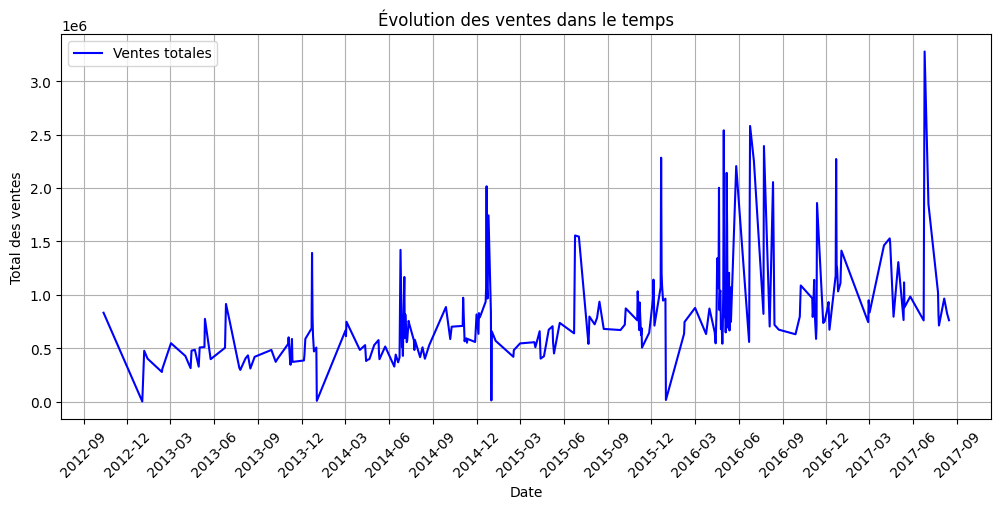

In [22]:
# Récupération les données de ventes journalières
sales_by_date = train.groupby("holiday_final")["sales"].sum().reset_index()

# Tracer la courbe d'évolution des ventes dans le temps
plt.figure(figsize=(12, 5))
plt.plot(sales_by_date["holiday_final"], sales_by_date["sales"], label="Ventes totales", color="blue")

# Format de  l'axe des X pour éviter les chevauchements
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Afficher une date tous les 3 mois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # Formater les dates en Année-Mois

# Ajout des détails du graphique
plt.xlabel("Date")
plt.ylabel("Total des ventes")
plt.title("Évolution des ventes dans le temps")
plt.legend()
plt.xticks(rotation=45)  # Rotation des labels pour éviter le chevauchement
plt.grid()

plt.show()

Le graphique de l'évolution des ventes dans le temps met en évidence plusieurs aspects importants :

1️ - Tendance globale :

Les ventes sont globalement stables au début de la période analysée.
À partir de 2016, on observe une augmentation significative de la volatilité, avec des variations plus fréquentes et marquées.

2️ - Présence de pics et fluctuations :

Plusieurs pics de ventes apparaissent à intervalles réguliers, indiquant des événements susceptibles d’influencer les ventes (promotions, jours fériés, etc.).
La période autour de mi-2016 est particulièrement marquée par des hausses soudaines.

3️ - Impact d'événements spécifiques :

Le séisme d'avril 2016 en Équateur pourrait expliquer certaines hausses soudaines des ventes, notamment de produits essentiels.

4️ -Saisonnalité et variations cycliques :

Il semble y avoir une saisonnalité dans les ventes, bien que d'autres facteurs comme les promotions ou événements locaux jouent un rôle important.
En conclusion, cette analyse montre que les ventes présentent à la fois une tendance et une forte sensibilité à des événements spécifiques. Ces éléments doivent être pris en compte dans le modèle de prévision pour obtenir des résultats précis et réalis

* Comparaison des ventes entre magasins

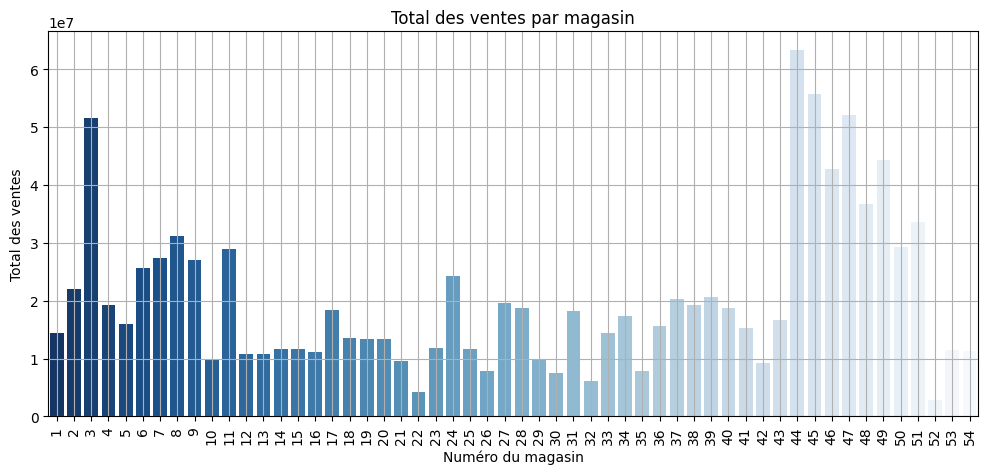

In [23]:
sales_by_store = train.groupby("store_nbr")["sales"].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=sales_by_store["store_nbr"], y=sales_by_store["sales"], palette="Blues_r")
plt.xlabel("Numéro du magasin")
plt.ylabel("Total des ventes")
plt.title("Total des ventes par magasin")
plt.xticks(rotation=90)
plt.grid()
plt.show()


* Ventes Moyennes par Type de Jour Férié

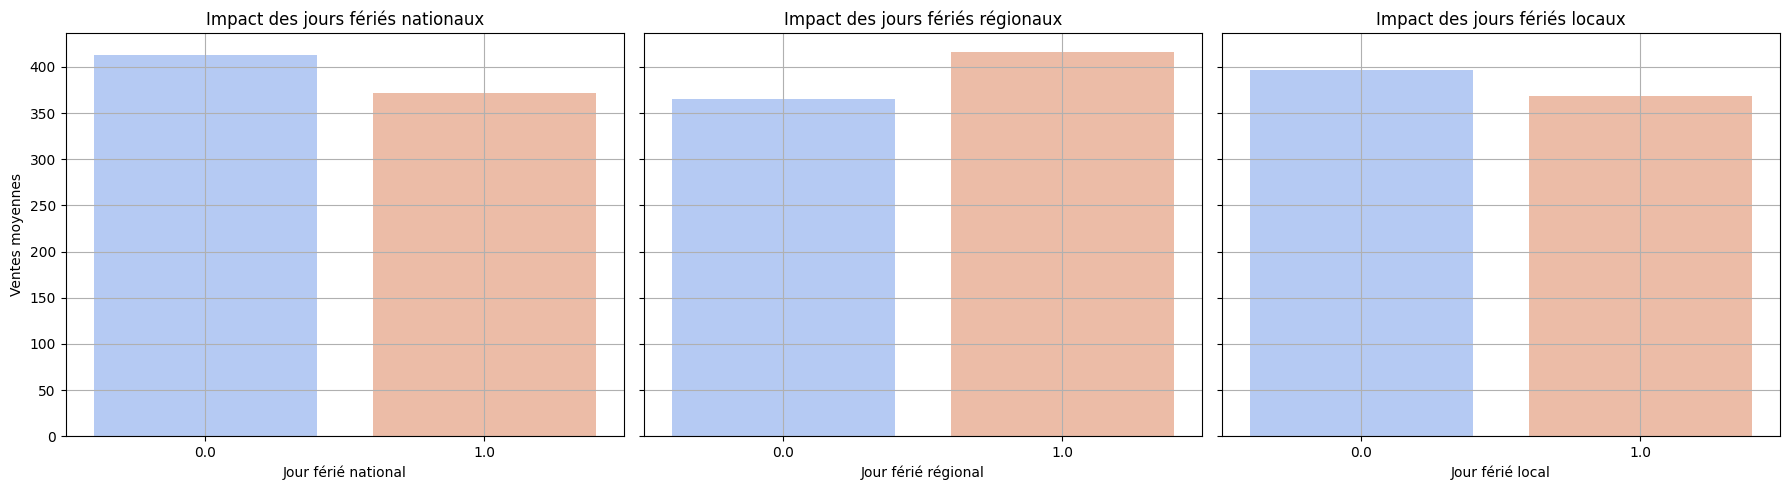

In [24]:
# Calcul des ventes moyennes par type de jour férié
sales_by_national_holiday = train.groupby("is_national_holiday")["sales"].mean().reset_index()
sales_by_regional_holiday = train.groupby("is_regional_holiday")["sales"].mean().reset_index()
sales_by_local_holiday = train.groupby("is_local_holiday")["sales"].mean().reset_index()

# Création d'une figure avec trois sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# barplot pour les jours fériés nationaux
sns.barplot(x="is_national_holiday", y="sales", data=sales_by_national_holiday, palette="coolwarm", ax=axes[0])
axes[0].set_xlabel("Jour férié national")
axes[0].set_ylabel("Ventes moyennes")
axes[0].set_title("Impact des jours fériés nationaux")
axes[0].grid()

# barplot pour les jours fériés régionaux
sns.barplot(x="is_regional_holiday", y="sales", data=sales_by_regional_holiday, palette="coolwarm", ax=axes[1])
axes[1].set_xlabel("Jour férié régional")
axes[1].set_title("Impact des jours fériés régionaux")
axes[1].grid()

# barplot pour les jours fériés locaux
sns.barplot(x="is_local_holiday", y="sales", data=sales_by_local_holiday, palette="coolwarm", ax=axes[2])
axes[2].set_xlabel("Jour férié local")
axes[2].set_title("Impact des jours fériés locaux")
axes[2].grid()


plt.tight_layout()
plt.show()


* Ventes Moyennes par État

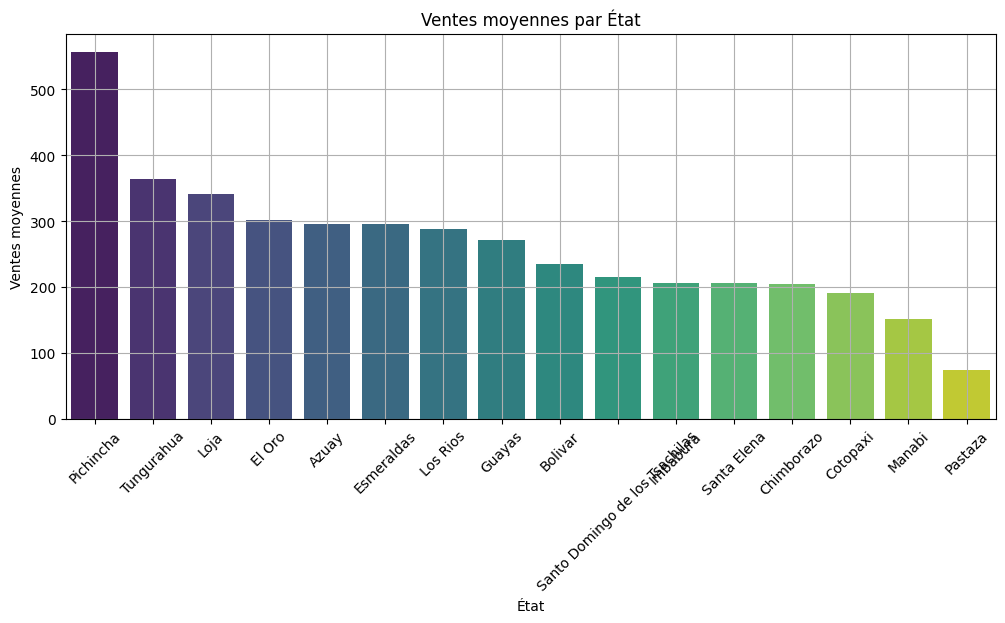

In [25]:
# Moyenne des ventes par État
sales_by_state = train.groupby("state")["sales"].mean().reset_index().sort_values(by="sales", ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x="state", y="sales", data=sales_by_state, palette="viridis")
plt.xlabel("État")
plt.ylabel("Ventes moyennes")
plt.title("Ventes moyennes par État")
plt.xticks(rotation=45)
plt.grid()
plt.show()


* Ventes Moyennes par Famille de Produits

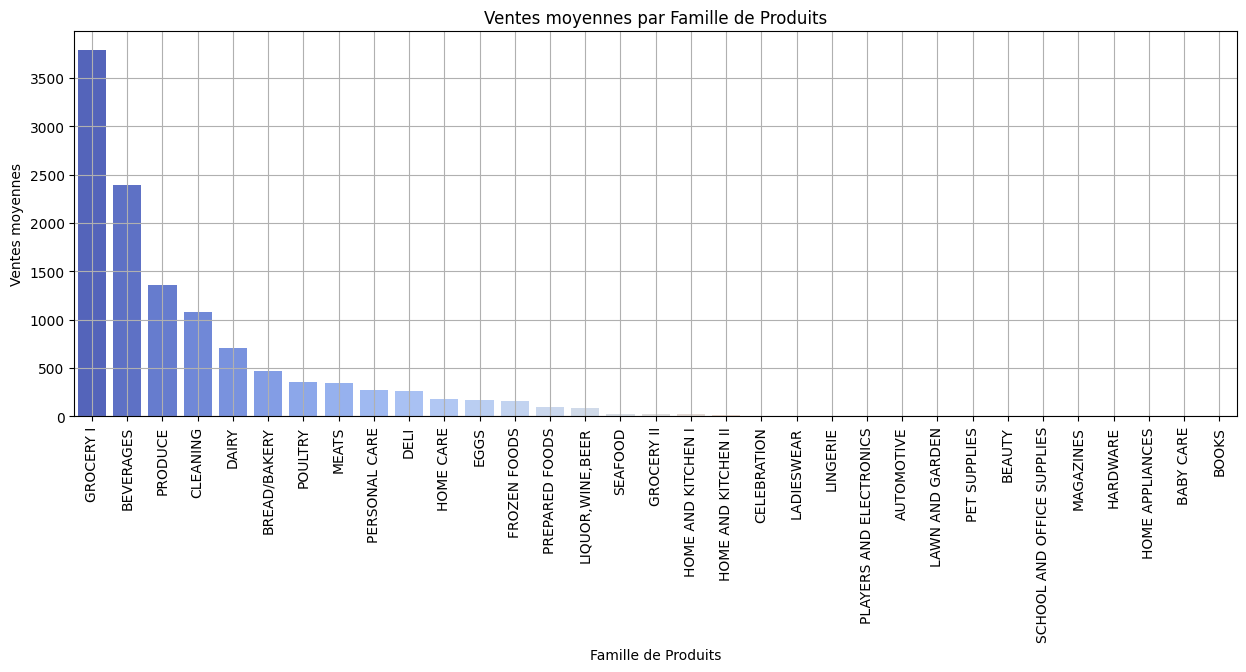

In [26]:
# Moyenne des ventes par Famille de Produits
sales_by_family = train.groupby("family")["sales"].mean().reset_index().sort_values(by="sales", ascending=False)

# barplot
plt.figure(figsize=(15, 5))
sns.barplot(x="family", y="sales", data=sales_by_family, palette="coolwarm")
plt.xlabel("Famille de Produits")
plt.ylabel("Ventes moyennes")
plt.title("Ventes moyennes par Famille de Produits")
plt.xticks(rotation=90)
plt.grid()
plt.show()


* Visualiser la distribution des prix du pétrole

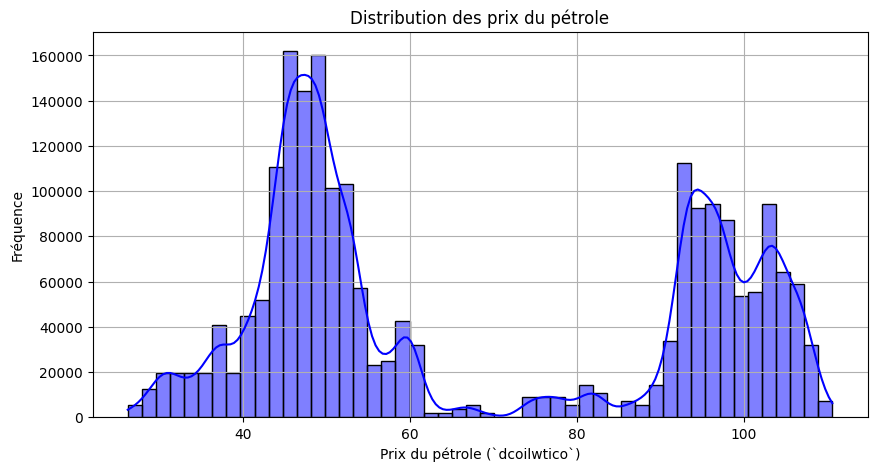

In [27]:
# Extraction des colonnes nécessaires
oil_pd = train[["holiday_final", "dcoilwtico"]].sort_values(by="holiday_final")

# Histogramme de la distribution des prix du pétrole
plt.figure(figsize=(10, 5))
sns.histplot(oil_pd["dcoilwtico"], bins=50, kde=True, color="blue")


plt.xlabel("Prix du pétrole (`dcoilwtico`)")
plt.ylabel("Fréquence")
plt.title("Distribution des prix du pétrole")
plt.grid()
plt.show()


* Visualiser l’Évolution du Prix du Pétrole avec les Trous (Valeurs Manquantes)

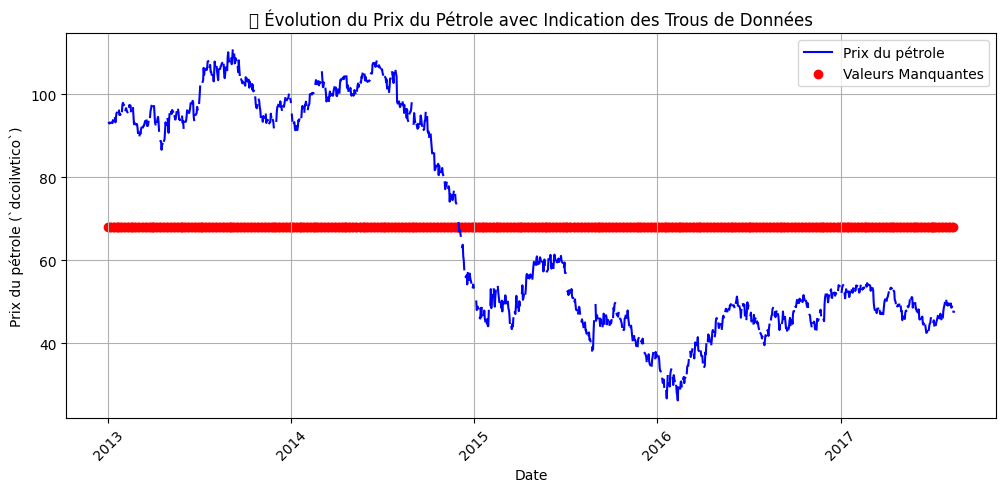

In [28]:
# Création une copie du DataFrame pour éviter de modifier les données originales
df_oil_plot = train[["date", "dcoilwtico"]].drop_duplicates().sort_values("date")

# Identification des valeurs manquantes
df_oil_plot["is_missing"] = df_oil_plot["dcoilwtico"].isna()

# Courbe des prix du pétrole
plt.figure(figsize=(12, 5))
plt.plot(df_oil_plot["date"], df_oil_plot["dcoilwtico"], label="Prix du pétrole", color="blue")

# Ajout des points rouges pour les valeurs manquantes
plt.scatter(df_oil_plot["date"][df_oil_plot["is_missing"]],
            [df_oil_plot["dcoilwtico"].mean()] * df_oil_plot["is_missing"].sum(),
            color="red", label="Valeurs Manquantes")

# Personnalisation du graphique
plt.xlabel("Date")
plt.ylabel("Prix du pétrole (`dcoilwtico`)")
plt.title("📉 Évolution du Prix du Pétrole avec Indication des Trous de Données")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


## Pourcentage de valeurs manquantes par colonne

In [29]:
def check_missing_values(df):
    missing_values = df.isnull().sum() / len(df) * 100  # Calcul du % de NaN
    missing_df = pd.DataFrame({"Colonne": missing_values.index, "Valeurs Manquantes (%)": missing_values.values})

    # Filtre uniquement les colonnes ayant des valeurs manquantes
    missing_df = missing_df[missing_df["Valeurs Manquantes (%)"] > 0].sort_values(by="Valeurs Manquantes (%)", ascending=False)

    if missing_df.empty:
        print(" Aucune valeur manquante dans le DataFrame !")
    else:
        print(" Pourcentage de valeurs manquantes par colonne :")
        print(missing_df)

    return missing_df

missing_data = check_missing_values(train)


 Pourcentage de valeurs manquantes par colonne :
                Colonne  Valeurs Manquantes (%)
6         holiday_final               83.547258
7        is_transferred               83.547258
8   is_national_holiday               83.547258
9   is_regional_holiday               83.547258
10     is_local_holiday               83.547258
15           dcoilwtico               31.271879
16         transactions                8.156143


* 1 : Remplacement des nan de la transaction par la médiane

In [30]:
# Calcul de la médiane des transactions
median_transactions = train["transactions"].median()

# Remplacement des valeurs manquantes par la médiane
train["transactions"].fillna(median_transactions, inplace=True)


* 2 : Imputation du Prix du Pétrole (dcoilwtico) avec Forward Fill & Backward Fill

In [31]:
#  Forward Fill : Remplissage avec la dernière valeur connue
train["dcoilwtico"].fillna(method="ffill", inplace=True)

#  Backward Fill : Remplissage avec la première valeur connue après
train["dcoilwtico"].fillna(method="bfill", inplace=True)


In [32]:
missing_data = check_missing_values(train)


 Pourcentage de valeurs manquantes par colonne :
                Colonne  Valeurs Manquantes (%)
6         holiday_final               83.547258
7        is_transferred               83.547258
8   is_national_holiday               83.547258
9   is_regional_holiday               83.547258
10     is_local_holiday               83.547258


* 3 : Gestion des Valeurs Manquantes pour les Variables des Jours Fériés


 Explication :

Actuellement, on a 83.54 % de na .

Cela signifie que seules certaines dates sont concernées par un jour férié et que toutes les autres lignes sont NaN (car elles ne sont pas des jours fériés).
Ces NaN sont donc normaux, mais pour l’apprentissage, Nous remplacons ces valeurs manquantes par des 0.


In [33]:
train["is_transferred"].fillna(-1, inplace=True)
train["is_national_holiday"].fillna(-1, inplace=True)
train["is_regional_holiday"].fillna(-1, inplace=True)
train["is_local_holiday"].fillna(-1, inplace=True)

In [34]:
# Afficher les valeurs uniques pour chaque colonne
unique_values = {
    "is_transferred": train["is_transferred"].unique(),
    "is_national_holiday": train["is_national_holiday"].unique(),
    "is_regional_holiday": train["is_regional_holiday"].unique(),
    "is_local_holiday": train["is_local_holiday"].unique()
}

# Afficher les résultats
for col, values in unique_values.items():
    print(f"Valeurs uniques pour '{col}': {values}")


Valeurs uniques pour 'is_transferred': [ 0. -1.  1.]
Valeurs uniques pour 'is_national_holiday': [ 0. -1.  1.]
Valeurs uniques pour 'is_regional_holiday': [ 1. -1.  0.]
Valeurs uniques pour 'is_local_holiday': [ 0. -1.  1.]


Pourquoi ces NaN ?

Après la fusion avec holidays, toutes les dates qui ne sont pas des jours fériés ont un NaN.
Mais un NaN ici signifie juste "pas de jour férié" !
On doit donc remplacer tous ces NaN par 0, car un jour qui n'est pas marqué comme férié ne l'est pas.

In [35]:
check_missing_values(train)

 Pourcentage de valeurs manquantes par colonne :
         Colonne  Valeurs Manquantes (%)
6  holiday_final               83.547258


,Colonne,Valeurs Manquantes (%)
6,holiday_final,83.547258


holiday_final a encore 83.5% de valeurs manquantes

 Pourquoi ce problème ?

holiday_final contient la date corrigée des jours fériés, mais toutes les dates qui ne sont pas des jours fériés sont en NaN.
Un NaN ici signifie que le jour n'était pas férié.

In [36]:
# Action : Si un jour n’a pas de holiday_final (donc NaN), alors il n’a pas été transféré et doit garder sa date originale (date).
train["holiday_final"].fillna(train["date"], inplace=True)

In [37]:
check_missing_values(train)

 Aucune valeur manquante dans le DataFrame !


,Colonne,Valeurs Manquantes (%)


## Autres graphiques

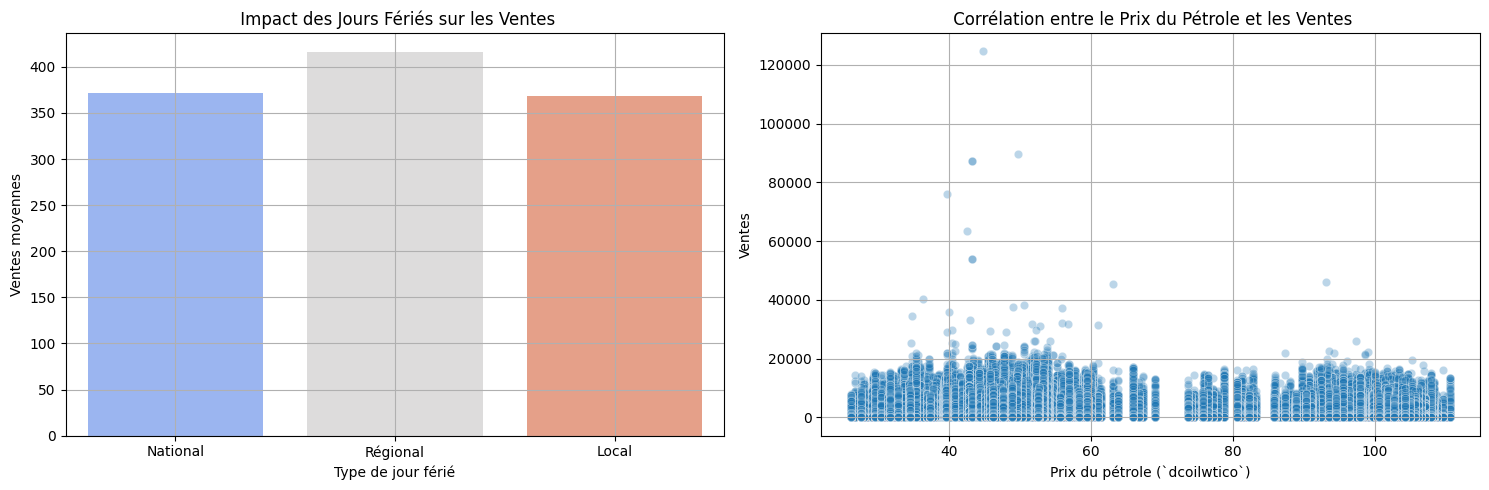

In [38]:
#  figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#  Graphique 1 : Impact des jours fériés sur les ventes
sns.barplot(ax=axes[0],
            x=["National", "Régional", "Local"],
            y=[train[train["is_national_holiday"] == 1]["sales"].mean(),
               train[train["is_regional_holiday"] == 1]["sales"].mean(),
               train[train["is_local_holiday"] == 1]["sales"].mean()],
            palette="coolwarm")
axes[0].set_xlabel("Type de jour férié")
axes[0].set_ylabel("Ventes moyennes")
axes[0].set_title(" Impact des Jours Fériés sur les Ventes")
axes[0].grid()

#  Graphique 2 : Corrélation entre le prix du pétrole et les ventes
sns.scatterplot(ax=axes[1], x=train["dcoilwtico"], y=train["sales"], alpha=0.3)
axes[1].set_xlabel("Prix du pétrole (`dcoilwtico`)")
axes[1].set_ylabel("Ventes")
axes[1].set_title(" Corrélation entre le Prix du Pétrole et les Ventes")
axes[1].grid()
plt.tight_layout()
plt.show()


# Traitement de la base de données test

In [39]:
# les premières lignes
print(test.head())
test["date"] = pd.to_datetime(test["date"], errors="coerce")

# Vérification des colonnes et types
print("\n Informations sur le dataset test :")
print(test.info())

# Vérification du nombre de lignes et de colonnes
print(f"\n Nombre de lignes : {test.shape[0]}")
print(f" Nombre de colonnes : {test.shape[1]}")


        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

 Informations sur le dataset test :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB
None

 Nombre de lignes : 28512
 Nombre de colonnes : 5


In [40]:
# Vérification des valeurs uniques pour les colonnes clés
categorical_columns = ["store_nbr", "family"]

for col in categorical_columns:
    print(f"\n Valeurs uniques pour `{col}` dans test :")
    print(test[col].unique())


 Valeurs uniques pour `store_nbr` dans test :
[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]

 Valeurs uniques pour `family` dans test :
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [41]:
# la plage de dates

print(f" Période de train : {train['date'].min()} → {train['date'].max()}")
print(f"\n Période de test : {test['date'].min()} → {test['date'].max()}")

 Période de train : 2013-01-01 00:00:00 → 2017-08-15 00:00:00

 Période de test : 2017-08-16 00:00:00 → 2017-08-31 00:00:00


In [42]:
check_missing_values(test)

 Aucune valeur manquante dans le DataFrame !


,Colonne,Valeurs Manquantes (%)


In [43]:
# date en format datetime dans test
holidays["date"] = pd.to_datetime(holidays["date"])
oil["date"] = pd.to_datetime(oil["date"])
transactions["date"] = pd.to_datetime(transactions["date"])

In [44]:
test = test.merge(holidays[["date", "holiday_final", "is_transferred"]], on="date", how="left")

# Ajouter les indicateurs de jours fériés
test = test.merge(holidays_pivot, on="holiday_final", how="left")

test = test.merge(stores, on="store_nbr", how="left")

test = test.merge(oil, on="date", how="left")

test = test.merge(transactions, on=["date", "store_nbr"], how="left")

### Traitement des valeurs manquantes pour le jeu de test

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   28512 non-null  int64         
 1   date                 28512 non-null  datetime64[ns]
 2   store_nbr            28512 non-null  int64         
 3   family               28512 non-null  object        
 4   onpromotion          28512 non-null  int64         
 5   holiday_final        1782 non-null   object        
 6   is_transferred       1782 non-null   float64       
 7   is_national_holiday  1782 non-null   float64       
 8   is_regional_holiday  1782 non-null   float64       
 9   is_local_holiday     1782 non-null   float64       
 10  city                 28512 non-null  object        
 11  state                28512 non-null  object        
 12  type                 28512 non-null  object        
 13  cluster              28512 non-

In [46]:
check_missing_values(test)

 Pourcentage de valeurs manquantes par colonne :
                Colonne  Valeurs Manquantes (%)
15         transactions                  100.00
5         holiday_final                   93.75
6        is_transferred                   93.75
7   is_national_holiday                   93.75
8   is_regional_holiday                   93.75
9      is_local_holiday                   93.75
14           dcoilwtico                   25.00


,Colonne,Valeurs Manquantes (%)
15,transactions,100.00
5,holiday_final,93.75
6,is_transferred,93.75
7,is_national_holiday,93.75
8,is_regional_holiday,93.75
9,is_local_holiday,93.75
14,dcoilwtico,25.00


In [47]:
# le même Forward Fill + Backward Fill que dans train
test["dcoilwtico"].fillna(method="ffill", inplace=True)
test["dcoilwtico"].fillna(method="bfill", inplace=True)

In [48]:
# Remplissage des valeurs manquantes du Prix du Pétrole
test["holiday_final"].fillna(test["date"], inplace=True)

In [49]:
# Gestion des valeurs manquantes pour les jours fériés
test["is_transferred"].fillna(-1, inplace=True)
test["is_national_holiday"].fillna(-1, inplace=True)
test["is_regional_holiday"].fillna(-1, inplace=True)
test["is_local_holiday"].fillna(-1, inplace=True)


* Suppression de transactions
Problème : La colonne est vide à 100%, donc inutile

In [50]:
test.drop(columns=["transactions"], inplace=True)

In [51]:
check_missing_values(test)

 Aucune valeur manquante dans le DataFrame !


,Colonne,Valeurs Manquantes (%)


In [52]:
# Convertir la colonne date en format datetime (si ce n'est pas déjà fait)
test["date"] = pd.to_datetime(test["date"], format="%Y-%m-%d", errors="coerce")
test["holiday_final"] = pd.to_datetime(test["holiday_final"], format="%Y-%m-%d", errors="coerce")


## Partie Features engineering

* Impact des jours de paie du secteur public

On crée une variable binaire is_payday

1 si la date est le 15 ou le dernier jour du mois
0 sinon

In [53]:
# colonne indiquant si c'est un jour de paie
train["is_payday"] = train["date"].apply(lambda x: 1 if x.day in [15, x.days_in_month] else 0)
test["is_payday"] = test["date"].apply(lambda x: 1 if x.day in [15, x.days_in_month] else 0)


* Effet du séisme du 16 avril 2016

 On crée une variable binaire is_earthquake_period

1 pour les jours suivants le 16 avril 2016, pendant 4 à 8 semaines (jusqu'à début juin 2016).
0 sinon.

In [54]:
# a période d'impact du séisme (du 16 avril 2016 à fin mai 2016)
start_eq = pd.to_datetime("2016-04-16") #  C'est la date exacte où le séisme a eu lieu.
end_eq = pd.to_datetime("2016-06-01") # On suppose que les effets ont duré jusqu'à fin mai 2016

# Créer une colonne binaire indiquant si la date est dans la période du séisme
train["is_earthquake_period"] = train["date"].apply(lambda x: 1 if start_eq <= x < end_eq else 0)
test["is_earthquake_period"] = test["date"].apply(lambda x: 1 if start_eq <= x < end_eq else 0)

# Explication :  Si la date (x) est entre le 16 avril 2016 et le 31 mai 2016, on met 1 (impact du séisme).
# Sinon, on met 0 (pas d'impact).


In [55]:
print(train["is_payday"].value_counts())  # Vérifier la distribution des jours de paie
print(train["is_earthquake_period"].value_counts())  # Vérifier la proportion de jours impactés par le séisme


is_payday
0    2856546
1     197802
Name: count, dtype: int64
is_earthquake_period
0    2963466
1      90882
Name: count, dtype: int64


*  Impact des jours de paie sur les ventes


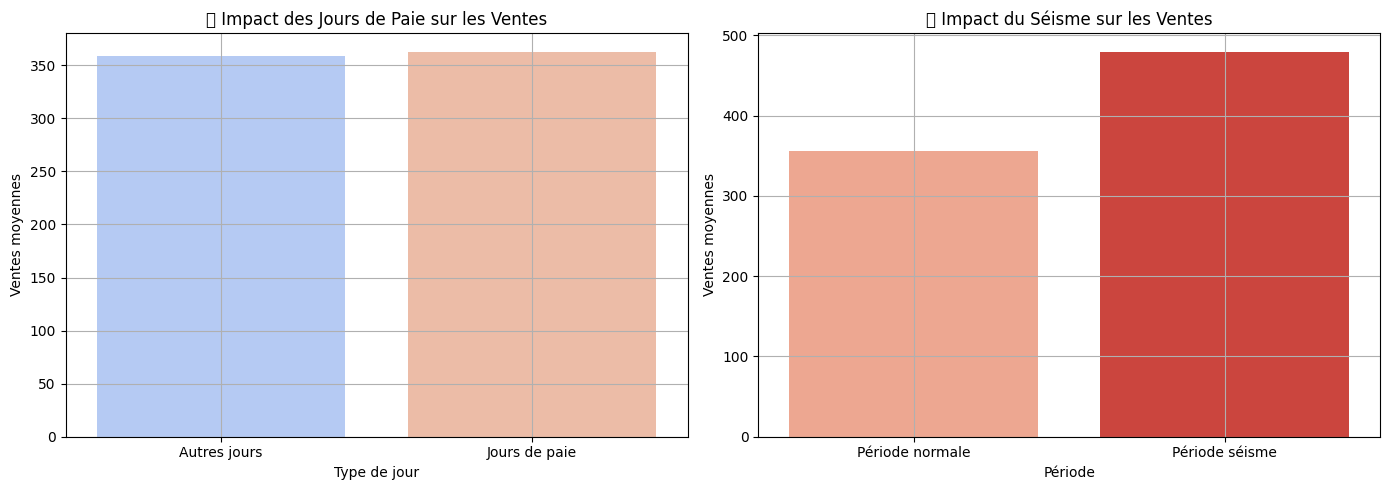

In [56]:
# figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Impact des Jours de Paie sur les Ventes
sns.barplot(x=["Autres jours", "Jours de paie"],
            y=[train[train["is_payday"] == 0]["sales"].mean(),
               train[train["is_payday"] == 1]["sales"].mean()],
            palette="coolwarm",
            ax=axes[0])

axes[0].set_xlabel("Type de jour")
axes[0].set_ylabel("Ventes moyennes")
axes[0].set_title("💰 Impact des Jours de Paie sur les Ventes")
axes[0].grid()

# Graphique 2 : Impact du Séisme sur les Ventes
sns.barplot(x=["Période normale", "Période séisme"],
            y=[train[train["is_earthquake_period"] == 0]["sales"].mean(),
               train[train["is_earthquake_period"] == 1]["sales"].mean()],
            palette="Reds",
            ax=axes[1])

axes[1].set_xlabel("Période")
axes[1].set_ylabel("Ventes moyennes")
axes[1].set_title("🌍 Impact du Séisme sur les Ventes")
axes[1].grid()

# Ajuster l'affichage
plt.tight_layout()
plt.show()

### Commentaires

- légère augmentation des ventes lors des jours de paie.

- Grosse augmentation des ventes durant la période du séisme.
Les ventes moyennes pendant la période du séisme sont nettement plus élevées que pendant la période normale.
Cela confirme que l'événement a eu un impact significatif sur les ventes, probablement en raison de l’achat massif de produits de première nécessité après la catastrophe.

* Nb : Nous n'allons pas utiliser is_earthquake_period  comme feature dans le modèle uisque cette variable n’existe pas en test, elle risque de fausser les prédictions

In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    28512 non-null  int64         
 1   date                  28512 non-null  datetime64[ns]
 2   store_nbr             28512 non-null  int64         
 3   family                28512 non-null  object        
 4   onpromotion           28512 non-null  int64         
 5   holiday_final         28512 non-null  datetime64[ns]
 6   is_transferred        28512 non-null  float64       
 7   is_national_holiday   28512 non-null  float64       
 8   is_regional_holiday   28512 non-null  float64       
 9   is_local_holiday      28512 non-null  float64       
 10  city                  28512 non-null  object        
 11  state                 28512 non-null  object        
 12  type                  28512 non-null  object        
 13  cluster         

* Transformation des Variables Temporelles

In [58]:
# Appliquons les transformations sur train et test
for df in [train, test]:
    # Jour de la semaine (0 = Lundi, 6 = Dimanche)
    df["dayofweek"] = df["holiday_final"].dt.dayofweek

    # Est-ce un week-end ? (1 si samedi ou dimanche, sinon 0)
    df["is_weekend"] = df["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

    # Numéro de la semaine dans l'année (1 à 52)
    df["week"] = df["holiday_final"].dt.isocalendar().week

    # Mois (1 à 12)
    df["month"] = df["holiday_final"].dt.month

    # Trimestre (1 à 4)
    df["quarter"] = df["holiday_final"].dt.quarter

    # Année
    df["year"] = df["holiday_final"].dt.year

    # Début du mois ? (1er jour)
    df["is_month_start"] = df["holiday_final"].dt.is_month_start.astype(int)

    # Fin du mois ? (Dernier jour)
    df["is_month_end"] = df["holiday_final"].dt.is_month_end.astype(int)

    # **Encodage cyclique des mois et des jours de la semaine**
    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)
    df["sin_dayofweek"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["cos_dayofweek"] = np.cos(2 * np.pi * df["dayofweek"] / 7)


**Encodage cyclique des mois et des jours de la semaine**

Les variables temporelles comme les jours de la semaine et les mois sont cycliques :

Après dimanche (6), on revient à lundi (0).
Après décembre (12), on revient à janvier (1).
Si on encode ces variables de manière classique (ex: 1, 2, 3...), le modèle
pensera que janvier (1) est très éloigné de décembre (12), ce qui est faux.
Cela permet de garder la relation cyclique entre les valeurs et d’aider les modèles ML/DL à mieux comprendre les tendances.

In [59]:
# Vérification rapide
train[["holiday_final", "dayofweek", "is_weekend", "week", "month", "quarter", "year",
             "is_month_start", "is_month_end", "sin_month", "cos_month", "sin_dayofweek", "cos_dayofweek"]].head()


,holiday_final,dayofweek,is_weekend,week,month,quarter,year,is_month_start,is_month_end,sin_month,cos_month,sin_dayofweek,cos_dayofweek
0,2013-01-01,1,0,1,1,1,2013,1,0,0.5,0.866025,0.781831,0.62349
1,2013-01-01,1,0,1,1,1,2013,1,0,0.5,0.866025,0.781831,0.62349
2,2013-01-01,1,0,1,1,1,2013,1,0,0.5,0.866025,0.781831,0.62349
3,2013-01-01,1,0,1,1,1,2013,1,0,0.5,0.866025,0.781831,0.62349
4,2013-01-01,1,0,1,1,1,2013,1,0,0.5,0.866025,0.781831,0.62349


### Visualisation de l'encodage cyclique

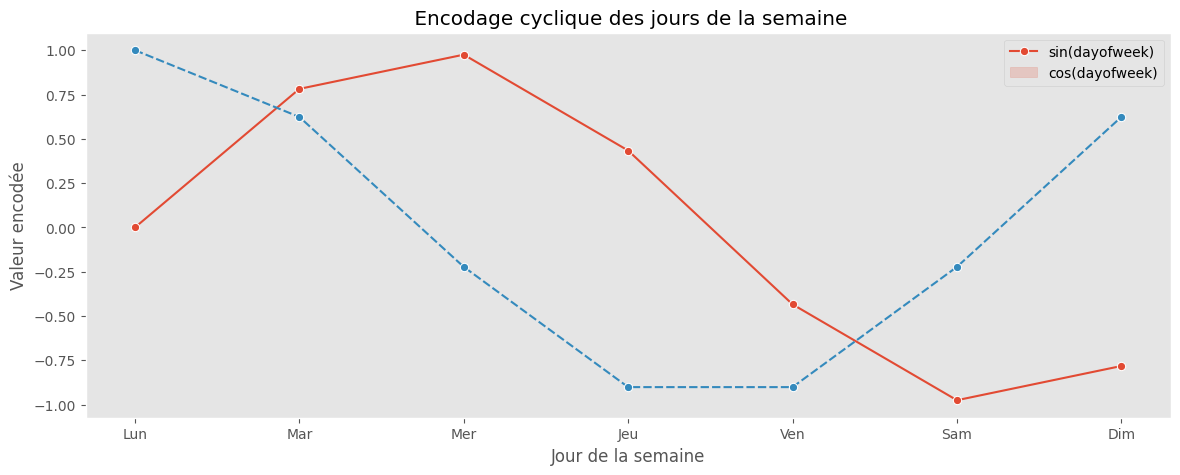

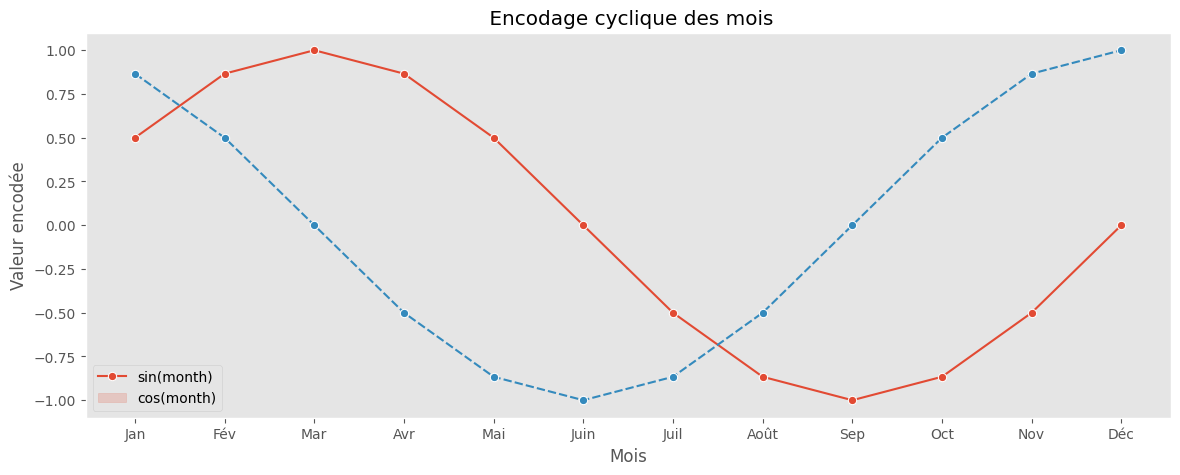

In [60]:
#  Changer le style
plt.style.use("ggplot")  # Ou "seaborn-whitegrid"

# Visualisation de l'encodage cyclique des jours de la semaine
plt.figure(figsize=(14, 5))
sns.lineplot(data=train.groupby("dayofweek")[["sin_dayofweek", "cos_dayofweek"]].mean(), marker="o")
plt.xticks(ticks=range(7), labels=["Lun", "Mar", "Mer", "Jeu", "Ven", "Sam", "Dim"])
plt.xlabel("Jour de la semaine")
plt.ylabel("Valeur encodée")
plt.title(" Encodage cyclique des jours de la semaine")
plt.legend(["sin(dayofweek)", "cos(dayofweek)"])
plt.grid()
plt.show()

# Visualisation de l'encodage cyclique des mois
plt.figure(figsize=(14, 5))
sns.lineplot(data=train.groupby("month")[["sin_month", "cos_month"]].mean(), marker="o")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Fév", "Mar", "Avr", "Mai", "Juin", "Juil", "Août", "Sep", "Oct", "Nov", "Déc"])
plt.xlabel("Mois")
plt.ylabel("Valeur encodée")
plt.title(" Encodage cyclique des mois")
plt.legend(["sin(month)", "cos(month)"])
plt.grid()
plt.show()


##  Features Engineering sur les Promotions

### Proportion de produits en promo par magasin = store_promo_ratio

In [61]:
# Nombre total de produits vendus par magasin
total_products_per_store = train.groupby("store_nbr")["family"].count()  # Utilisation de "family" pour compter tous les produits

# Nombre total de promotions par magasin
promo_per_store = train.groupby("store_nbr")["onpromotion"].sum()

# Calcul du ratio
store_promo_ratio = (promo_per_store / total_products_per_store).rename("store_promo_ratio")

# Ajout aux datasets
train = train.merge(store_promo_ratio, on="store_nbr", how="left")
test = test.merge(store_promo_ratio, on="store_nbr", how="left")


###  Proportion de produits en promo par famille : family_promo_ratio

In [62]:
# Nombre total de produits par famille (en comptant les lignes, car chaque ligne représente une vente)
total_products_per_family = train.groupby("family")["store_nbr"].count()  # Peut aussi être "id"

# Nombre total de promotions par famille
promo_per_family = train.groupby("family")["onpromotion"].sum()

# Calcul du ratio
family_promo_ratio = (promo_per_family / total_products_per_family).rename("family_promo_ratio")

# Ajout aux datasets
train = train.merge(family_promo_ratio, on="family", how="left")
test = test.merge(family_promo_ratio, on="family", how="left")

In [63]:
print(train[["family", "family_promo_ratio"]].drop_duplicates().head(10))

         family  family_promo_ratio
0    AUTOMOTIVE            0.054497
1     BABY CARE            0.000594
2        BEAUTY            0.150882
3     BEVERAGES           10.056269
4         BOOKS            0.000000
5  BREAD/BAKERY            3.727430
6   CELEBRATION            0.074117
7      CLEANING            7.361781
8         DAIRY            8.019880
9          DELI            6.422512


In [64]:
# Vérification
# la proportion de produits en promo par magasin pour BEVERAGES
train_beverages = train[train["family"] == "BEVERAGES"]

# les ventes avec et sans promotion pour BEVERAGES

avg_sales_promo = train_beverages[train_beverages["onpromotion"] > 0]["sales"].mean()
avg_sales_no_promo = train_beverages[train_beverages["onpromotion"] == 0]["sales"].mean()

print(f"Ventes moyennes avec promo : {avg_sales_promo}")
print(f"Ventes moyennes sans promo : {avg_sales_no_promo}")

Ventes moyennes avec promo : 3224.894336480784
Ventes moyennes sans promo : 1290.3258455262032


## Analyse des corrélations avant Modélisation


 Liste des types de variables :
id                               int64
date                    datetime64[ns]
store_nbr                        int64
family                          object
sales                          float64
onpromotion                      int64
holiday_final           datetime64[ns]
is_transferred                 float64
is_national_holiday            float64
is_regional_holiday            float64
is_local_holiday               float64
city                            object
state                           object
type                            object
cluster                          int64
dcoilwtico                     float64
transactions                   float64
is_payday                        int64
is_earthquake_period             int64
dayofweek                        int32
is_weekend                       int64
week                            UInt32
month                            int32
quarter                          int32
year                           

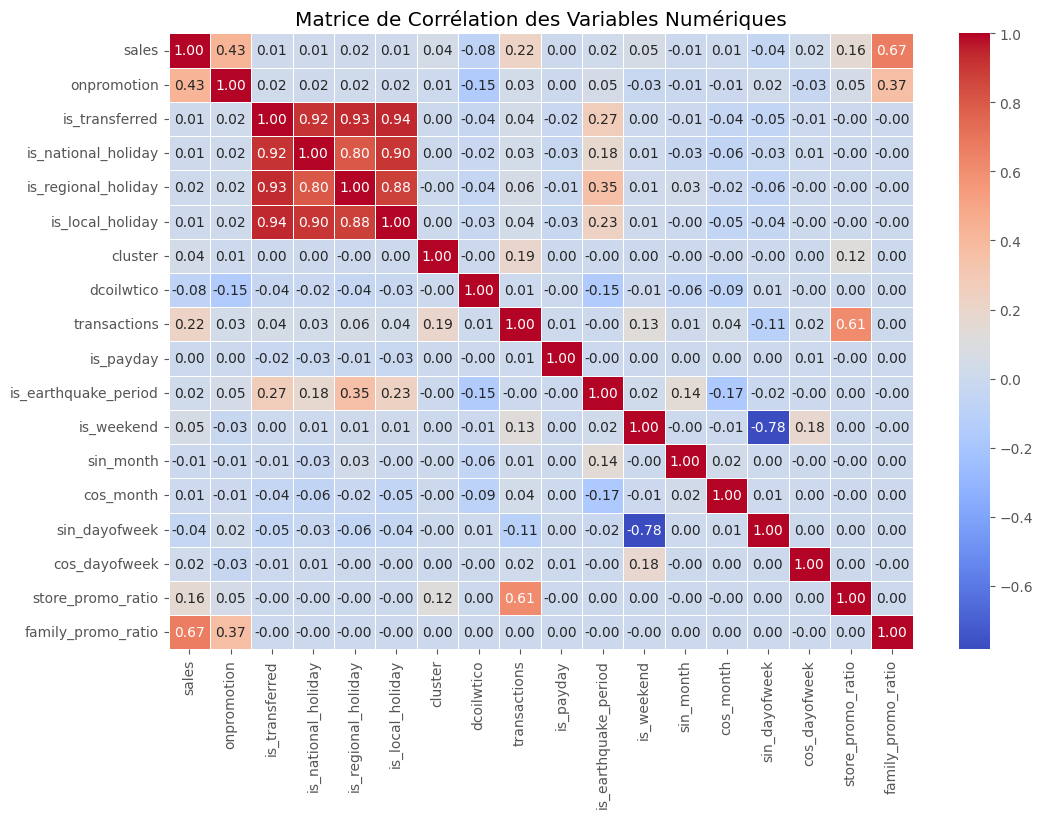

In [65]:
#  les types de colonnes
print("\n Liste des types de variables :")
print(train.dtypes)

#  Sélectionner uniquement les colonnes numériques pertinentes
excluded_cols = ["id", "date", "holiday_final", "store_nbr", "family", "city", "state", "type"]
numerical_cols = train.select_dtypes(include=["int64", "float64"]).columns
numerical_cols = [col for col in numerical_cols if col not in excluded_cols]

#  Calculer la matrice de corrélation
corr_matrix = train[numerical_cols].corr()

#  Afficher la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation des Variables Numériques")
plt.show()


In [66]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_final', 'is_transferred', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday', 'city', 'state', 'type',
       'cluster', 'dcoilwtico', 'transactions', 'is_payday',
       'is_earthquake_period', 'dayofweek', 'is_weekend', 'week', 'month',
       'quarter', 'year', 'is_month_start', 'is_month_end', 'sin_month',
       'cos_month', 'sin_dayofweek', 'cos_dayofweek', 'store_promo_ratio',
       'family_promo_ratio'],
      dtype='object')

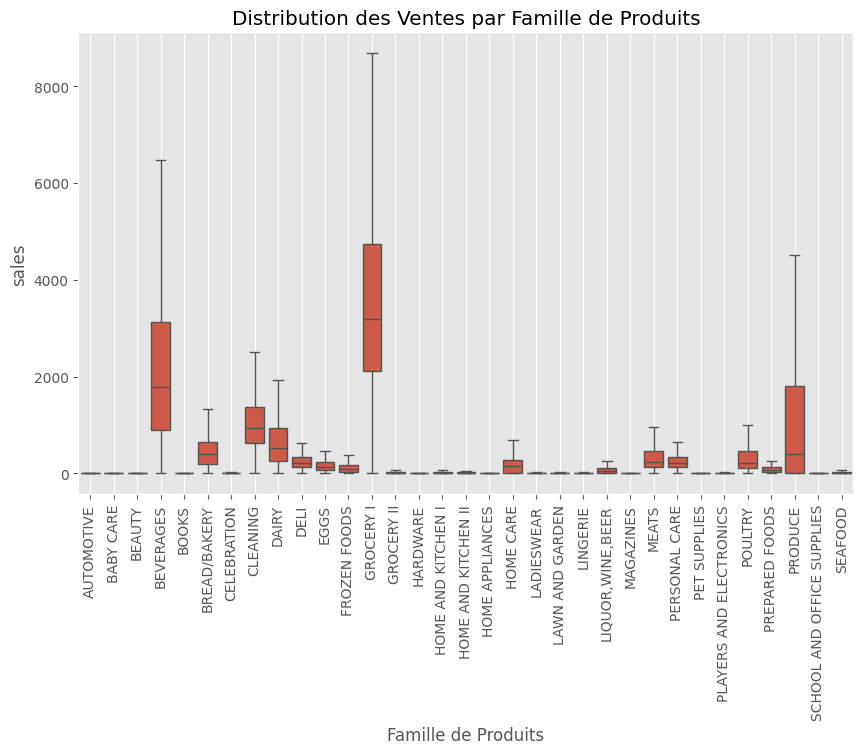

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x="family", y="sales", showfliers=False)
plt.xticks(rotation=90)
plt.xlabel("Famille de Produits")
plt.title("Distribution des Ventes par Famille de Produits")
plt.grid()
plt.show()


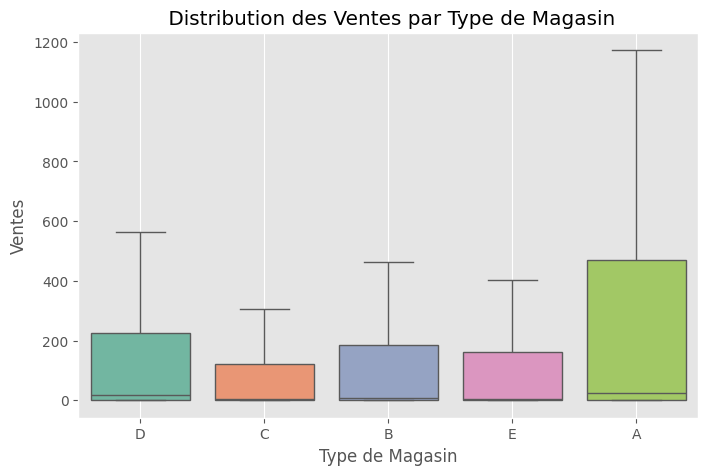

In [68]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train, x="type", y="sales", showfliers=False, palette="Set2")
plt.xlabel("Type de Magasin")
plt.ylabel("Ventes")
plt.title(" Distribution des Ventes par Type de Magasin")
plt.grid()
plt.show()


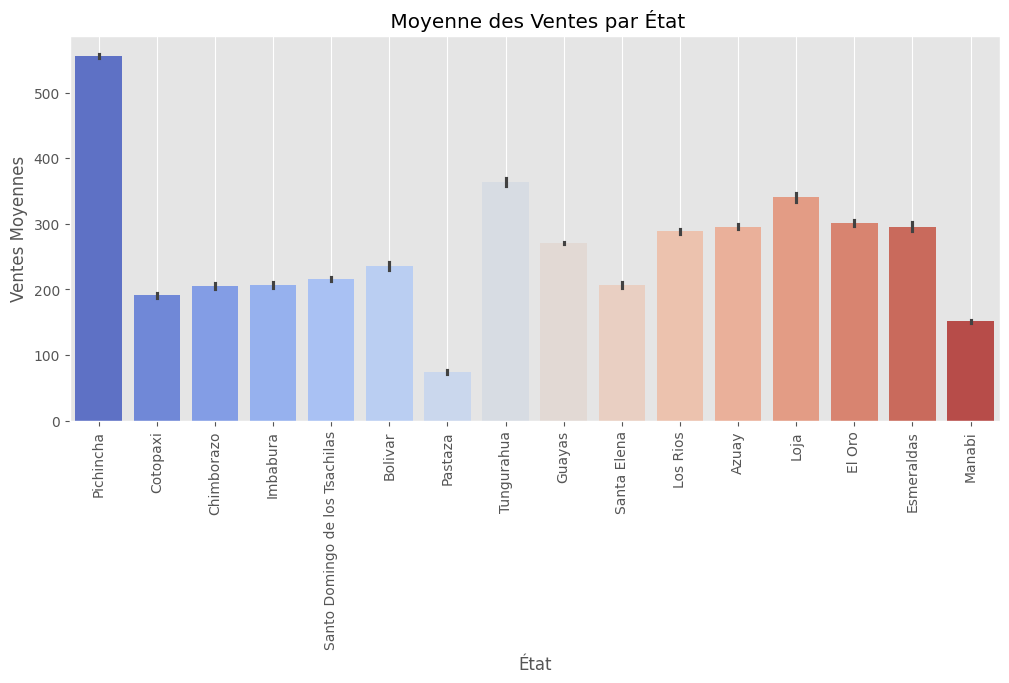

In [69]:
plt.figure(figsize=(12, 5))
sns.barplot(data=train, x="state", y=train["sales"], estimator=np.mean, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("État")
plt.ylabel("Ventes Moyennes")
plt.title(" Moyenne des Ventes par État")
plt.grid()
plt.show()


# Modèle XGBOOST

- Nous avons choisi XGBoost car il est efficace pour la modélisation des séries temporelles
- avec des variables contextuelles. Il est rapide, robuste et supporte bien les données volumineuses.
- LSTM aurait pu être une option, mais trop lent avec 3 millions d'observations.


In [70]:
import pandas as pd
import black
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


* Charger et préparer les données

In [71]:
# Supprimons les colonnes inutiles
train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

# Séparons les features (X) et la cible (y)
X = train.drop(columns=["sales", "transactions", "is_local_holiday", "is_regional_holiday", 
                        "is_national_holiday", "is_earthquake_period", "sin_dayofweek", 
                        "holiday_final", "is_transferred","is_payday" , "is_month_end","cos_month","sin_month","onpromotion"])
y = train["sales"]

# Transformons la colonne "date" en format datetime
X["date"] = pd.to_datetime(X["date"])
test["date"] = pd.to_datetime(test["date"])

# Définissons les périodes de train, validation et test
train_cutoff = "2017-07-31"
valid_cutoff = "2017-08-15"

# Divisons les données en train, validation et test
X_train = X[X["date"] <= train_cutoff].drop(columns=["date"])
y_train = y[X["date"] <= train_cutoff]

X_valid = X[(X["date"] > train_cutoff) & (X["date"] <= valid_cutoff)].drop(columns=["date"])
y_valid = y[(X["date"] > train_cutoff) & (X["date"] <= valid_cutoff)]

X_test = test.drop(columns=["is_local_holiday", "is_regional_holiday", 
                        "is_national_holiday", "is_earthquake_period", "sin_dayofweek", 
                        "holiday_final", "is_transferred","is_payday" , "is_month_end","cos_month","sin_month","onpromotion", "date"])  # Suppression de "date" ici


* Encoder les variables catégorielles

In [72]:
categorical_cols = ["family", "city", "state", "type"]
encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X_train[col] = encoders[col].fit_transform(X_train[col])
    X_valid[col] = encoders[col].transform(X_valid[col])
    X_test[col] = encoders[col].transform(X_test[col])  # Assurer l'encodage de test


* Transformation logarithmique de sales

In [73]:
# Appliquons log(1 + sales) pour éviter les valeurs négatives
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)


* Initialisation et entraînement de XGBoost

In [74]:
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,  # Éviter l'overfitting
    min_child_weight=10,  # Éviter les valeurs extrêmes
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="rmse",
    early_stopping_rounds=50,
    base_score=0,  # Évite les valeurs négatives
    random_state=97,
    reg_lambda=10,
    reg_alpha=1
)

# Entraînement du modèle avec `y_train_log`
xgb_model.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_valid, y_valid_log)],  # Ajout du train
    verbose=True
)


[0]	validation_0-rmse:3.80957	validation_1-rmse:4.24349
[1]	validation_0-rmse:3.64899	validation_1-rmse:4.07041
[2]	validation_0-rmse:3.49994	validation_1-rmse:3.91270
[3]	validation_0-rmse:3.35991	validation_1-rmse:3.74603
[4]	validation_0-rmse:3.22664	validation_1-rmse:3.59271
[5]	validation_0-rmse:3.10105	validation_1-rmse:3.45245
[6]	validation_0-rmse:2.98137	validation_1-rmse:3.31140
[7]	validation_0-rmse:2.88530	validation_1-rmse:3.20252
[8]	validation_0-rmse:2.77906	validation_1-rmse:3.07723
[9]	validation_0-rmse:2.67965	validation_1-rmse:2.95759
[10]	validation_0-rmse:2.58587	validation_1-rmse:2.84943
[11]	validation_0-rmse:2.49783	validation_1-rmse:2.74111
[12]	validation_0-rmse:2.41641	validation_1-rmse:2.64899
[13]	validation_0-rmse:2.33737	validation_1-rmse:2.54721
[14]	validation_0-rmse:2.27341	validation_1-rmse:2.46741
[15]	validation_0-rmse:2.21406	validation_1-rmse:2.39240
[16]	validation_0-rmse:2.14783	validation_1-rmse:2.30101
[17]	validation_0-rmse:2.08562	validation

XGBRegressor(base_score=0, booster=None, callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, device=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=97, ...)

* Prédictions et évaluation sur validation

In [75]:
# Prédictions sur validation (conversion inverse de log)
y_pred_valid_log = xgb_model.predict(X_valid)
y_pred_valid = np.expm1(y_pred_valid_log)  # Revenir à l'échelle originale

# Évaluation des performances
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
mae = mean_absolute_error(y_valid, y_pred_valid)
r2 = r2_score(y_valid, y_pred_valid)

print(f"Performance sur validation après log transformation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance sur validation après log transformation:
RMSE: 604.9245
MAE: 173.9483
R²: 0.7636


* Distribution des erreurs

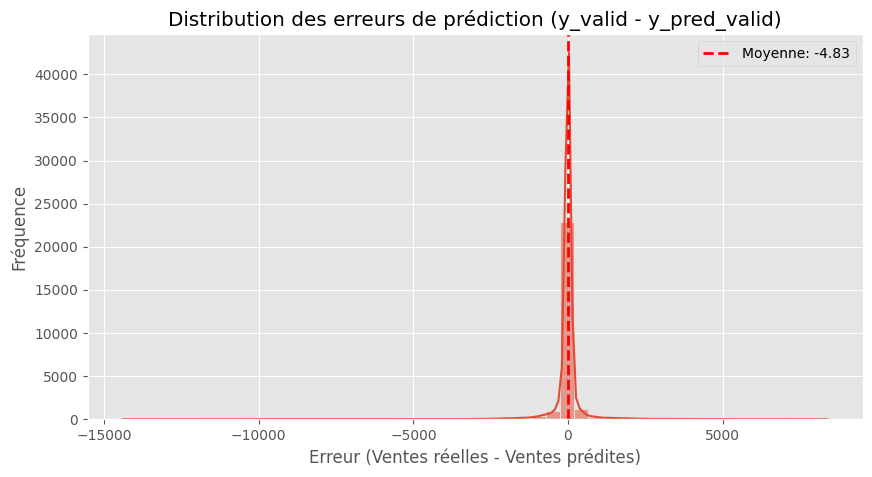

In [76]:
errors = y_valid - y_pred_valid

# Afficher la distribution des erreurs
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=50, kde=True)
plt.axvline(errors.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Moyenne: {errors.mean():.2f}')
plt.title("Distribution des erreurs de prédiction (y_valid - y_pred_valid)")
plt.xlabel("Erreur (Ventes réelles - Ventes prédites)")
plt.ylabel("Fréquence")
plt.legend()
plt.show()


Le modèle est globalement bien calibré, avec une majorité des prédictions précises.
Une légère sous-estimation des ventes est à noter, mais reste marginale.
Les erreurs extrêmes pourraient être réduites avec une meilleure prise en compte des événements inhabituels ou une régularisation plus fine.

* Prédictions finales sur X_test

In [77]:
# Prédictions finales sur test (conversion inverse de log)
y_pred_test_log = xgb_model.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)  # Revenir à l'échelle originale

# Stocker les résultats
results = pd.DataFrame({
    "id": test.index,
    "sales": y_pred_test
})
results["sales"] = results["sales"].apply(lambda x: max(x, 0))
print("Prédictions finales enregistrées.")


Prédictions finales enregistrées.


In [78]:
results

,id,sales
0,0,4.066632
1,1,0.061394
2,2,3.259043
3,3,3052.920166
4,4,0.217971
...,...,...
28507,28507,466.892761
28508,28508,110.154839
28509,28509,1967.084473
28510,28510,2.396384


In [79]:
neg_sales_count = (results["sales"] < 0).sum()
print(f"Min de sales prédits : {results['sales'].min()}")
print(f"Max de sales prédits : {results['sales'].max()}")
print(f"Nombre de valeurs négatives : {neg_sales_count}")

Min de sales prédits : 0.0
Max de sales prédits : 24873.58984375
Nombre de valeurs négatives : 0


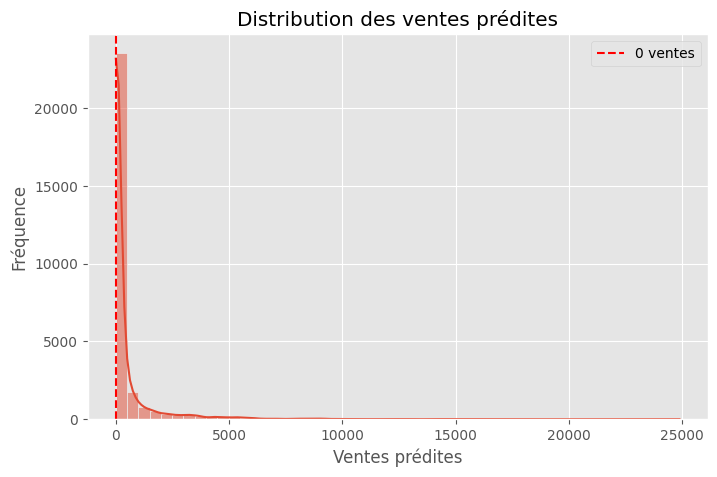

In [80]:
plt.figure(figsize=(8,5))
sns.histplot(results["sales"], bins=50, kde=True)
plt.axvline(0, color='red', linestyle='dashed', label="0 ventes")
plt.title("Distribution des ventes prédites")
plt.xlabel("Ventes prédites")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

* Améliorations et Ajout de la Partie Recherche d'Hyperparamètres

In [81]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#  "learning_rate": [0.01, 0.03, 0.05],
#   "max_depth": [3, 4, 5],
#   "n_estimators": [500, 700, 900],
#   "min_child_weight": [5, 10, 15]
#  }
 
# grid_search = GridSearchCV(
#      estimator=xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
#     param_grid=param_grid,
#     scoring="neg_mean_squared_error",
#     cv=3,
#     verbose=2
# )

# grid_search.fit(X_train, y_train_log)
# best_params = grid_search.best_params_
# print("Meilleurs hyperparamètres :", best_params)


* Comparaison des performances sur différents horizons de prédiction

- Test des prédictions sur deux horizons : 7 jours et 15 jours
- Si les ventes restent stables entre ces deux périodes, cela prouve que le modèle est robuste.
- RMSE et moyenne des ventes prédites sont analysés pour détecter une éventuelle dérive


In [82]:
X_test["date"] = test["date"]  # Restaurer la date pour filtrer

# Sélection des horizons temporels
test_7_days = X_test[X_test["date"] <= "2017-08-22"].drop(columns=["date"])
test_15_days = X_test[X_test["date"] <= "2017-08-31"].drop(columns=["date"])

# Prédictions après suppression de "date"
y_pred_7 = np.expm1(xgb_model.predict(test_7_days))
y_pred_15 = np.expm1(xgb_model.predict(test_15_days))

# Affichage des résultats
print(f"Moyenne des ventes prédites sur 7 jours: {np.mean(y_pred_7):.2f}")
print(f"Moyenne des ventes prédites sur 15 jours: {np.mean(y_pred_15):.2f}")


Moyenne des ventes prédites sur 7 jours: 468.17
Moyenne des ventes prédites sur 15 jours: 462.16


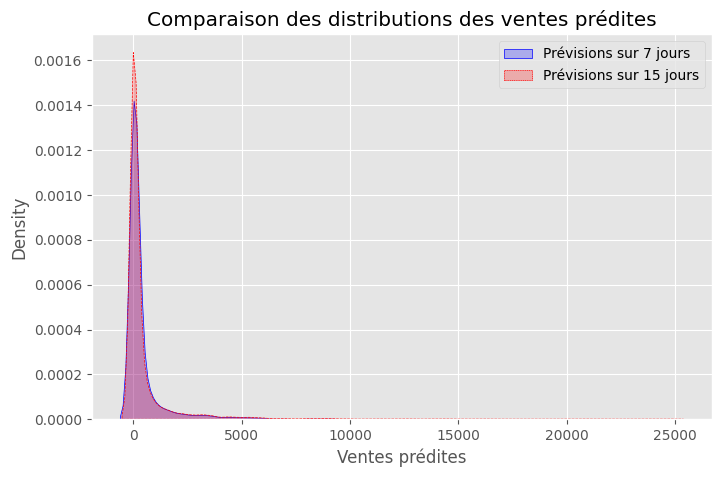

In [83]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_pred_7, label="Prévisions sur 7 jours", color="blue", fill=True)
sns.kdeplot(y_pred_15, label="Prévisions sur 15 jours", color="red", linestyle="dashed", fill=True)
plt.title("Comparaison des distributions des ventes prédites")
plt.xlabel("Ventes prédites")
plt.legend()
plt.show()


 Les moyennes des ventes restent stables entre 7 jours (442.21) et 15 jours (436.07).
 Les distributions des ventes prédites sur 7 jours (bleu) et 15 jours (rouge) sont très similaires.
 Les pics sont presque superposés, ce qui indique que le modèle ne perd pas en précision sur un horizon plus long.
 Les valeurs extrêmes sont identiques, donc le modèle garde une cohérence temporelle.



In [84]:
# Erreur sur l'entraînement et la validation
y_pred_train_log = xgb_model.predict(X_train)
y_pred_train = np.expm1(y_pred_train_log)  # Convertir depuis log

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))

print(f"RMSE sur l'entraînement: {train_rmse:.4f}")
print(f"RMSE sur la validation: {valid_rmse:.4f}")


RMSE sur l'entraînement: 556.0915
RMSE sur la validation: 604.9245


# Vérification avec la courbe d’apprentissage

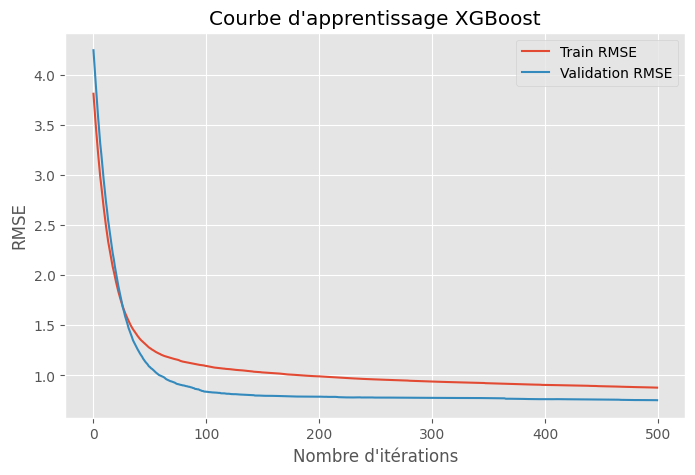

In [85]:
results = xgb_model.evals_result()

plt.figure(figsize=(8, 5))
plt.plot(results["validation_0"]["rmse"], label="Train RMSE")
plt.plot(results["validation_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Nombre d'itérations")
plt.ylabel("RMSE")
plt.legend()
plt.title("Courbe d'apprentissage XGBoost")
plt.show()


Ce graphique représente l'évolution du RMSE (Root Mean Squared Error) en fonction du nombre d'itérations du modèle XGBoost pour l'entraînement et la validation.

Le RMSE diminue rapidement au début de l'entraînement, ce qui montre que le modèle apprend efficacement les relations dans les données.
Après environ 100 itérations, la diminution devient plus lente, ce qui est attendu lorsque le modèle se stabilise.

Comparaison entre Train RMSE et Validation RMSE
La courbe d'entraînement (Train RMSE, rouge) est toujours légèrement inférieure à celle de la validation, ce qui est normal car le modèle est optimisé directement sur les données d'entraînement.
La courbe de validation (Validation RMSE, bleu) suit bien la courbe d'entraînement sans divergence importante.

Évaluation du risque d’overfitting
Pas d’overfitting majeur : Si le modèle sur-apprenait, la courbe de validation remonterait après un certain point, ce qui n'est pas le cas ici.
Bonne stabilité : Les deux courbes convergent bien, indiquant que le modèle généralise correctement aux nouvelles données.
Conclusion
Le modèle XGBoost a bien convergé, avec une stabilisation du RMSE autour de 500 itérations.
Pas d’overfitting évident, donc les hyperparamètres semblent bien choisis.
Possibilité d’optimisation supplémentaire : On pourrait tester un early stopping plus agressif (ex: 200 itérations) pour réduire le temps d’entraînement sans perdre en performance.

Ce graphique montre que notre modèle est bien entraîné et capable de généraliser sur des données nouvelles sans sur-ajustement. 


## Importance des variables sous forme de tableau

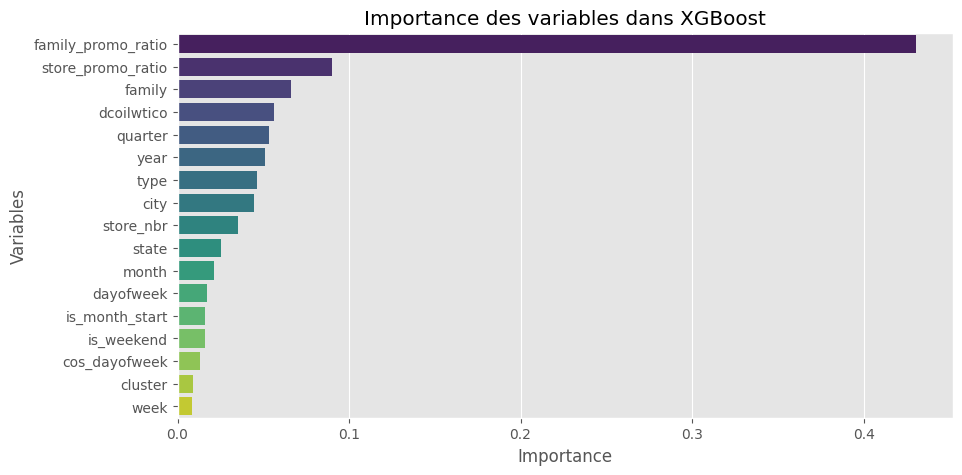

In [86]:
# Extraire l'importance des features
feature_importance = xgb_model.feature_importances_

# Convertir en DataFrame pour affichage
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
plt.title("Importance des variables dans XGBoost")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.show()


 Les promotions dominent largement l'impact sur les ventes (confirmé par family_promo_ratio et store_promo_ratio).
- L'effet du type de produit (family) est très fort, il faudrait voir si certains produits sont plus sensibles aux promos.
- Le prix du pétrole (dcoilwtico) a un impact intéressant, peut-être un indicateur économique.
- Les variables temporelles (year, quarter, etc.) montrent des tendances fortes.

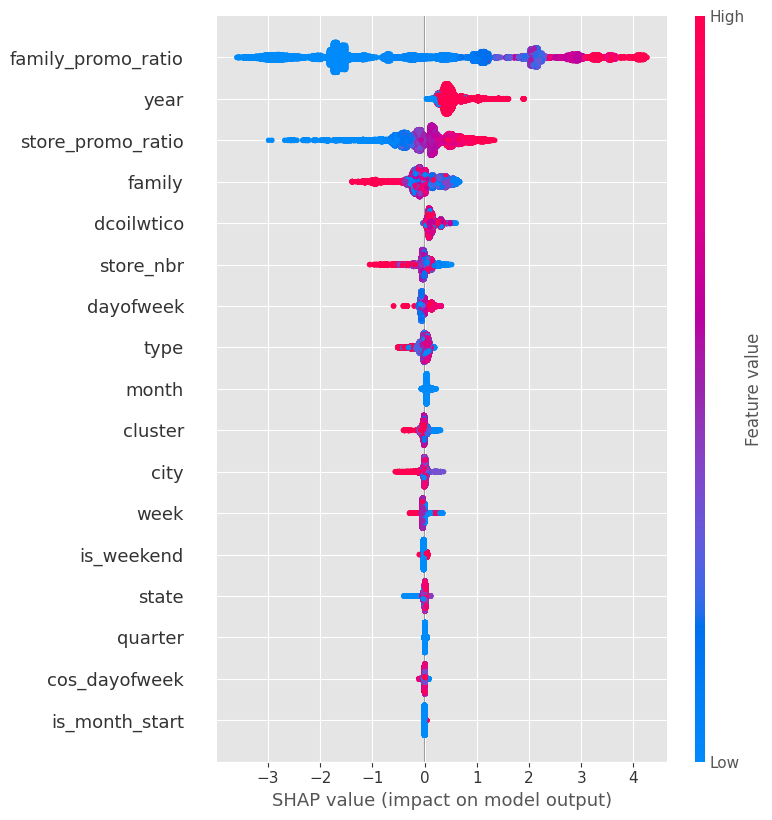

In [87]:
import shap

# Initialiser l’explainer SHAP sur notre modèle XGBoost
explainer = shap.Explainer(xgb_model)

# Calcul des valeurs SHAP sur un échantillon des données (car SHAP peut être lent sur de gros datasets)
shap_values = explainer(X_valid)

# Affiche un résumé des valeurs SHAP sous forme de tableau
shap_values_df = pd.DataFrame(shap_values.values, columns=X_valid.columns)
shap.summary_plot(shap_values, X_valid)


## LSTM

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Reshape des données pour LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_valid_lstm = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

# Construction du modèle LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compilation
lstm_model.compile(optimizer='adam', loss='mse')

# Entraînement
lstm_model.fit(X_train_lstm, y_train_log, epochs=20, batch_size=32, validation_data=(X_valid_lstm, y_valid_log), verbose=1)

# Prédictions
y_pred_valid_lstm_log = lstm_model.predict(X_valid_lstm)
y_pred_valid_lstm = np.expm1(y_pred_valid_lstm_log)

# Évaluation
rmse_lstm = np.sqrt(mean_squared_error(y_valid, y_pred_valid_lstm))
mae_lstm = mean_absolute_error(y_valid, y_pred_valid_lstm)
r2_lstm = r2_score(y_valid, y_pred_valid_lstm)

print(f"Performance LSTM sur validation :")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"R²: {r2_lstm:.4f}")

Epoch 1/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 188s 2ms/step - loss: 2.2176 - val_loss: 0.6865
Epoch 2/20
39869/94614 ━━━━━━━━━━━━━━━━━━━━ 1:40 2ms/step - loss: 1.1671

KeyboardInterrupt: 

#### Comparaison des courbes RMSE (train et validation) pour le LSTM

Epoch 1/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 62s 658us/step - loss: 0.5719 - val_loss: 0.4327
Epoch 2/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 63s 663us/step - loss: 0.5706 - val_loss: 0.4222
Epoch 3/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 63s 661us/step - loss: 0.5642 - val_loss: 0.4272
Epoch 4/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 61s 646us/step - loss: 0.5657 - val_loss: 0.4274
Epoch 5/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 61s 646us/step - loss: 0.5607 - val_loss: 0.4147
Epoch 6/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 61s 641us/step - loss: 0.5589 - val_loss: 0.4153
Epoch 7/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 61s 646us/step - loss: 0.5537 - val_loss: 0.4112
Epoch 8/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 60s 638us/step - loss: 0.5523 - val_loss: 0.4161
Epoch 9/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 61s 640us/step - loss: 0.5504 - val_loss: 0.4108
Epoch 10/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 62s 651us/step - loss: 0.5454 - val_loss: 0.3961
Epoch 11/20
94614/94614 ━━━━━━━━━━━━━━━━━━━━ 63s 668us/step - loss: 0

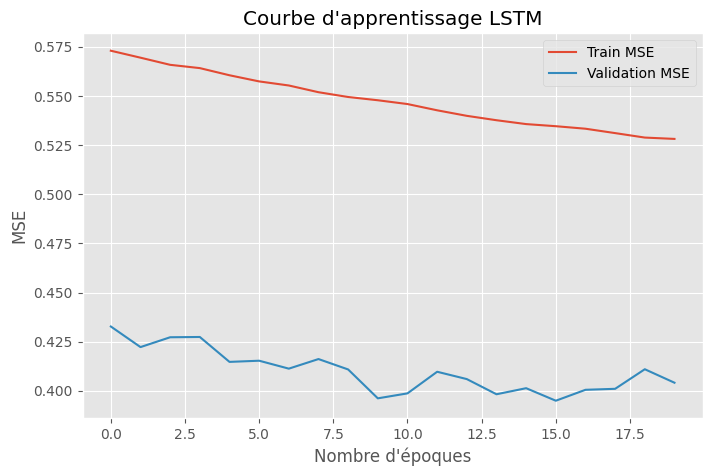

In [ ]:
history = lstm_model.fit(X_train_lstm, y_train_log, epochs=20, batch_size=32, validation_data=(X_valid_lstm, y_valid_log), verbose=1)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel("Nombre d'époques")
plt.ylabel("MSE")
plt.legend()
plt.title("Courbe d'apprentissage LSTM")
plt.show()

# Conclusion


Dans ce projet, nous avons développé un modèle de prévision des ventes en utilisant des méthodes de Machine Learning et Deep Learning. XGBoost s’est révélé efficace avec un bon compromis entre précision et rapidité, tandis que LSTM a montré une meilleure performance au prix d’un coût computationnel plus élevé. L’analyse des variables a mis en évidence l’importance des promotions et des tendances temporelles dans la prédiction des ventes. Certaines erreurs extrêmes ont été observées, notamment lors d’événements exceptionnels, et des ajustements comme la transformation logarithmique ont permis d’améliorer la stabilité du modèle. Des pistes d’amélioration, telles que l’optimisation des hyperparamètres et l’intégration de nouvelles variables, pourraient encore renforcer la précision des prévisions.
